# Pre-processing of avalanche warning data for machine learning


In [4]:
import sys
import pandas as pd  # check out Modin https://towardsdatascience.com/get-faster-pandas-with-modin-even-on-your-laptops-b527a2eeda74
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add path to APS modules
aps_pth = Path('.').absolute()
print(aps_pth)
if aps_pth not in sys.path:
    sys.path.append(aps_pth)
sns.set(style="white")
#from sklearn.preprocessing import LabelEncoder
#from pprint import pprint

#pd.set_option("display.max_rows",6)

%matplotlib inline

D:\Dev\APS


In [5]:
# analysis of entire data set - collected using varsomdata2.varsomscripts.avalanchewarningscomplete.get_season_17_18()
data_pth = Path(r'.\aps\data\varsom\norwegian_avalanche_warnings_season_17_18.csv')
data_pth = Path(r'D:\Dev\APS\aps\data\varsom\norwegian_avalanche_warnings_season_17_18.csv')

#varsom_df = pd.read_csv(aps_pth / data_pth, index_col=0)
varsom_df = pd.read_csv(data_pth, index_col=0)
varsom_df.head()

,author,avalanche_danger,avalanche_problem_1_advice,avalanche_problem_1_cause_id,avalanche_problem_1_cause_name,avalanche_problem_1_destructive_size_ext_id,avalanche_problem_1_destructive_size_ext_name,avalanche_problem_1_distribution_id,avalanche_problem_1_distribution_name,avalanche_problem_1_exposed_height_1,...,region_id,region_name,region_type_id,region_type_name,snow_surface,utm_east,utm_north,utm_zone,valid_from,valid_to
index,,,,,,,,,,,,,,,,,,,,,
0,Karsten@NVE,Det er lite snø og generelt stabile forhold i ...,Vær varsom der skredproblemet er å finne i ko...,15,Dårlig binding mellom lag i fokksnøen,2,2 - Middels,1,Få bratte heng,0,...,3003,Nordenskiöld Land,10,A,Det er generelt lite snø i terrenget. Rygger e...,520332,8663904,33,2017-12-01 00:00:00,2017-12-01 23:59:59
1,jan arild@obskorps,Kraftig vind fra sørøst vil gi pålagring av fe...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3007,Vest-Finnmark,10,A,Siste dagene har det kommet 25-30 cm snø utsat...,802123,7794717,33,2017-12-01 00:00:00,2017-12-01 23:59:59
2,jan arild@obskorps,"Generelle stabile forhold, men vindøkning fra ...",Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3009,Nord-Troms,10,A,Siste dagene har det kommet 20-30 cm snø utsat...,750984,7742562,33,2017-12-01 00:00:00,2017-12-01 23:59:59
3,jan arild@obskorps,Vindøkning fra sør vil gi pålagring av fersk f...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3010,Lyngen,10,A,Siste dagene har det kommet 10-20 cm snø utsat...,692056,7719872,33,2017-12-01 00:00:00,2017-12-01 23:59:59
4,jan arild@obskorps,Kraftig vind fra sør vil gi pålagring av fersk...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3011,Tromsø,10,A,Siste dagene har det kommet 25-40 cm snø utsat...,656496,7764237,33,2017-12-01 00:00:00,2017-12-01 23:59:59


Check if there are missing values.

In [6]:
# for col in varsom_df.columns.values:
#     print(f'{col}: {varsom_df[col].unique()} \n')

In [7]:
# Find the amount of NaN values in each column
print(varsom_df.isnull().sum().sort_values(ascending=False))

mountain_weather_change_wind_direction           2509
mountain_weather_change_hour_of_day_start        2491
mountain_weather_change_hour_of_day_stop         2491
mountain_weather_change_wind_speed               2483
mountain_weather_fl_hour_of_day_stop             1543
mountain_weather_fl_hour_of_day_start            1543
latest_observations                              1161
latest_avalanche_activity                         821
mountain_weather_freezing_level                   417
current_weak_layers                               247
mountain_weather_wind_direction                    74
mountain_weather_temperature_max                   45
mountain_weather_temperature_min                   44
mountain_weather_temperature_elevation             30
mountain_weather_precip_most_exposed                6
mountain_weather_precip_region                      4
avalanche_problem_2_advice                          2
avalanche_problem_1_advice                          2
mountain_weather_wind_speed 

Fill missing values where necessary.

In [8]:
varsom_df['mountain_weather_wind_speed'] = varsom_df['mountain_weather_wind_speed'].fillna('None')
varsom_df['mountain_weather_wind_direction'] = varsom_df['mountain_weather_wind_direction'].fillna('None')
print(varsom_df.isnull().sum().sort_values(ascending=False))

mountain_weather_change_wind_direction           2509
mountain_weather_change_hour_of_day_stop         2491
mountain_weather_change_hour_of_day_start        2491
mountain_weather_change_wind_speed               2483
mountain_weather_fl_hour_of_day_start            1543
mountain_weather_fl_hour_of_day_stop             1543
latest_observations                              1161
latest_avalanche_activity                         821
mountain_weather_freezing_level                   417
current_weak_layers                               247
mountain_weather_temperature_max                   45
mountain_weather_temperature_min                   44
mountain_weather_temperature_elevation             30
mountain_weather_precip_most_exposed                6
mountain_weather_precip_region                      4
avalanche_problem_2_advice                          2
avalanche_problem_1_advice                          2
avalanche_problem_2_distribution_id                 0
avalanche_problem_2_destruct

## Feature engineering
Re-label og -classifiy variables where necessary.

Add an avalanche problem severity index - based on its attributes size, distribution and sensitivity.


In [9]:
from aps.notebooks.ml_varsom.regroup_forecast import regroup
varsom_df = regroup(varsom_df)

FileNotFoundError: [Errno 2] No such file or directory: '../../config/snoskred_keys.json'

Add historical values, e.g. yesterdays precipitation

Add a tag to the feature name to indicate if it is categorical (c) or numerical (n).
Add a target tag (t).
Add a modelled (m) or observed (o) tag.

_prev1day
_prev3day

n_f_Next24HourChangeInTempFromPrev3DayMax - change of temperature over a certain period.
n_r_Prev7dayMinTemp2InPast - ???
n_r_SNOWDAS_SnowpackAveTemp_k2InPast - modelled average temperature from model SNOWDAS (? https://nsidc.org/data/g02158)



In [11]:
# Check if sensitivity transformation worked...
print(varsom_df['avalanche_problem_1_sensitivity_id_class'].value_counts())

KeyError: 'avalanche_problem_1_sensitivity_id_class'

In [27]:
varsom_df['mountain_weather_precip_region_prev1day'] = varsom_df['mountain_weather_precip_region'].shift(1)
varsom_df['mountain_weather_precip_most_exposed_prev1day'] = varsom_df['mountain_weather_precip_most_exposed'].shift(1)

varsom_df['mountain_weather_precip_region_prev3daysum'] = varsom_df['mountain_weather_precip_region'].shift(1) + varsom_df['mountain_weather_precip_region'].shift(2) + varsom_df['mountain_weather_precip_region'].shift(3)

varsom_df.filter(['mountain_weather_precip_region', 'mountain_weather_precip_region_prev3daysum']).head(12)

,mountain_weather_precip_region,mountain_weather_precip_region_prev3daysum
index,,
0,2.0,NaN
1,2.0,NaN
2,3.0,NaN
3,7.0,7.0
4,6.0,12.0
5,8.0,16.0
6,4.0,21.0
7,12.0,18.0
8,9.0,24.0


Combine avalanche problem attributes into single parameter

In [13]:
def get_aval_problem_combined(type_, dist_, sens_, size_):
    return int(f"{type_}{dist_}{sens_}{size_}")


def print_aval_problem_combined(aval_combined_int):
    aval_combined_str = str(aval_combined_int)
    with open(aps_pth / r'aps/config/snoskred_keys.json') as jdata:
        snoskred_keys = json.load(jdata)
    type_ = snoskred_keys["Class_AvalancheProblemTypeName"][aval_combined_str[0]]
    dist_ = snoskred_keys["Class_AvalDistributionName"][aval_combined_str[1]]
    sens_ = snoskred_keys["Class_AvalSensitivityId"][aval_combined_str[2]]
    size_ = snoskred_keys["Class_AvalDistributionName"][aval_combined_str[3]]
    
    return f"{type_}:{dist_}:{sens_}:{size_}"

print(print_aval_problem_combined(6221))
    
    
    
varsom_df['aval_problem_1_combined'] = varsom_df.apply(lambda row: get_aval_problem_combined(row['avalanche_problem_1_problem_type_id_class'],
                                                                                     row['avalanche_problem_1_distribution_id'],
                                                                                     row['avalanche_problem_1_sensitivity_id_class'], #avalanche_problem_1_trigger_simple_id_class / avalanche_problem_1_sensitivity_id_class
                                                                                     row['avalanche_problem_1_destructive_size_ext_id']), axis=1)

aval_uni = varsom_df['aval_problem_1_combined'].unique()
print(aval_uni, len(aval_uni))
print(varsom_df['aval_problem_1_combined'].value_counts())
print(varsom_df['avalanche_problem_1_problem_type_id_class'].value_counts())

Wind slab:Specific:Stubborn:Isolated


KeyError: ('avalanche_problem_1_problem_type_id_class', 'occurred at index 0')

Hot encode categorical variables where necessary.

In [14]:
# hot encode
hot_encode_ = ['emergency_warning', 'author', 'mountain_weather_wind_direction']
varsom_df = pd.get_dummies(varsom_df, columns=hot_encode_)

Check if there are no weired or missing values.

In [15]:
# Check if there are no weired or missing values.
for col in varsom_df.columns.values:
    print(f'{col}: {varsom_df[col].unique()} \n')

avalanche_danger: ['Det er lite snø og generelt stabile forhold i regionen. Det er kun i enkelte bratte leformasjoner som har samlet mye snø at det er mulig å løse ut snøskred.'
 'Kraftig vind fra sørøst vil gi pålagring av fersk fokksnø som vil trenge tid til å stabilisere seg. Det er fortsatt lett å løse ut skred i fokksnøen de steder hvor denne fokksnøen har lagt seg. Det finnes også vedvarende svake lag av kantkorn som er med på å styre skredfaren.\r\nSkredfaren vurderes til faregrad 2-moderat for regionen som helhet. '
 'Generelle stabile forhold, men vindøkning fra sør vil gi pålagring av fersk fokksnø i leområder. Skred i dette kan lett løses ut de steder hvor fokksnøen legger seg. Skredfaren styres også av utbredelse av kantkornlag som er observert i deler av regionen. Skred på dette kan lett løses ut hvor snødekket er tynt.\r\nSkredfaren vurderes til faregrad 2-moderat for regionen.'
 ...
 'Regionen har generelt stabile forhold med et forutsigbart snødekke som har gjennomgått 

Remove variables we know we do not need. In this case mainly because they are redundant like the _avalanche\_problem\_1\_ext\_name_ and _avalanche\_problem\_1\_ext\_id_ - in this case we only keep the numeric _id_ variable.

In [16]:
del_list = [
    'utm_zone',
    'utm_east',
    'utm_north',
    'danger_level_name',
    'avalanche_problem_1_exposed_height_fill',
    'avalanche_problem_2_exposed_height_fill',
    'avalanche_problem_3_exposed_height_fill',
    'avalanche_problem_1_valid_expositions',
    'avalanche_problem_2_valid_expositions',
    'avalanche_problem_3_valid_expositions',
    'avalanche_problem_1_cause_name',
    'avalanche_problem_1_problem_type_name',
    'avalanche_problem_1_destructive_size_ext_name',
    'avalanche_problem_1_distribution_name',
    'avalanche_problem_1_ext_name',
    'avalanche_problem_1_probability_name',
    'avalanche_problem_1_trigger_simple_name',
    'avalanche_problem_1_type_name',
    'avalanche_problem_2_cause_name',
    'avalanche_problem_2_problem_type_name',
    'avalanche_problem_2_destructive_size_ext_name',
    'avalanche_problem_2_distribution_name',
    'avalanche_problem_2_ext_name',
    'avalanche_problem_2_probability_name',
    'avalanche_problem_2_trigger_simple_name',
    'avalanche_problem_2_type_name',
    'avalanche_problem_3_cause_name',
    'avalanche_problem_3_problem_type_name',
    'avalanche_problem_3_destructive_size_ext_name',
    'avalanche_problem_3_distribution_name',
    'avalanche_problem_3_ext_name',
    'avalanche_problem_3_probability_name',
    'avalanche_problem_3_trigger_simple_name',
    'avalanche_problem_3_type_name',
    'latest_avalanche_activity',
    'main_text',
    'snow_surface',
    'current_weak_layers',
    'avalanche_danger',
    'avalanche_problem_1_advice',
    'avalanche_problem_2_advice',
    'avalanche_problem_3_advice',
    'mountain_weather_wind_speed',
    'region_type_name',
    'region_name',
    'reg_id',
    'valid_from',
    'valid_to'
]
removed_ = [varsom_df.pop(v) for v in del_list]

Fill missing values where necessary

In [28]:
fill_list = [
    'mountain_weather_freezing_level',
    'mountain_weather_precip_region',
    'mountain_weather_precip_region_prev1day',
    'mountain_weather_precip_region_prev3daysum',
    'mountain_weather_precip_most_exposed',
    'mountain_weather_precip_most_exposed_prev1day',
    'mountain_weather_temperature_min',
    'mountain_weather_temperature_max',
    'mountain_weather_temperature_elevation'
]
filled_ = [varsom_df[v].fillna(0., inplace=True) for v in fill_list]

Eventually remove variables with many missing values.

In [18]:
del_list = [
    'mountain_weather_change_wind_direction',
    'mountain_weather_change_hour_of_day_start',
    'mountain_weather_change_hour_of_day_stop',
    'mountain_weather_change_wind_speed',
    'mountain_weather_fl_hour_of_day_stop',
    'mountain_weather_fl_hour_of_day_start',
    'latest_observations'
]
removed_ = [varsom_df.pop(v) for v in del_list]

Check again if there are still values missing...

In [19]:
# Find the amount of NaN values in each column
print(varsom_df.isnull().sum().sort_values(ascending=False))

mountain_weather_wind_direction_W                0
avalanche_problem_3_trigger_simple_id            0
avalanche_problem_3_destructive_size_ext_id      0
avalanche_problem_3_distribution_id              0
avalanche_problem_3_exposed_height_1             0
avalanche_problem_3_exposed_height_2             0
avalanche_problem_3_ext_id                       0
avalanche_problem_3_probability_id               0
avalanche_problem_3_problem_id                   0
avalanche_problem_3_problem_type_id              0
avalanche_problem_3_type_id                      0
avalanche_problem_2_type_id                      0
danger_level                                     0
date_valid                                       0
mountain_weather_freezing_level                  0
mountain_weather_precip_most_exposed             0
mountain_weather_precip_region                   0
mountain_weather_temperature_elevation           0
mountain_weather_temperature_max                 0
mountain_weather_temperature_mi

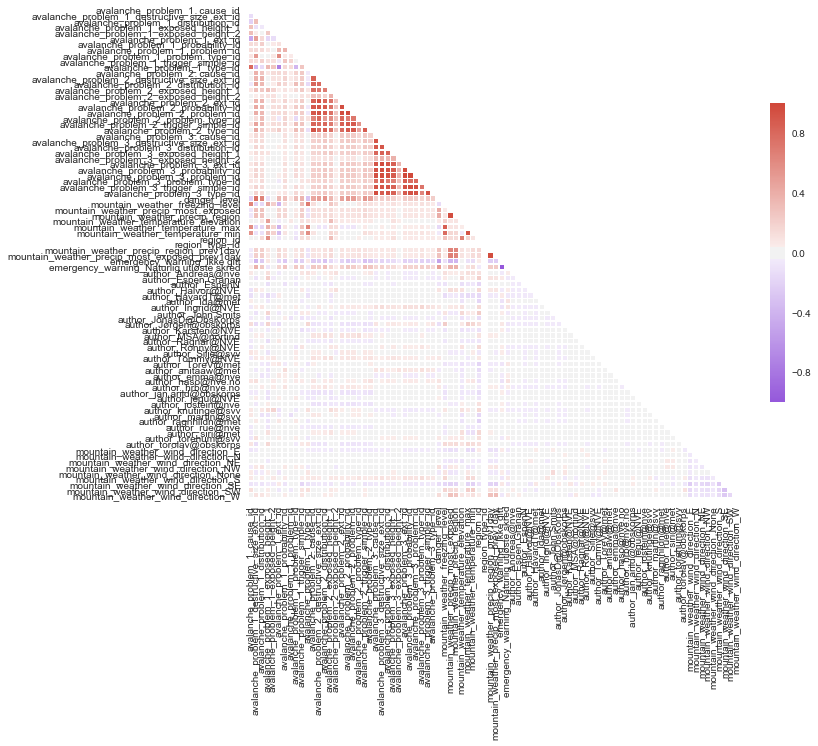

In [20]:
# Compute the correlation matrix - works only on numerical variables.
corr = varsom_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(1000, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can see that some parameters are highly correlated. These are mainly the parameters belonging to the same avalanche problem. Depending on the ML algorithm we use we have to remove some of them.

In [ ]:
#corr['avalanche_problem_1_cause_id'].sort_values(ascending=False)
#corr

In [22]:
#sns.pairplot(varsom_df.drop(['date_valid'], axis=1))

In [23]:
# let's see the details about remainig variables 

varsom_df.describe()

,avalanche_problem_1_cause_id,avalanche_problem_1_destructive_size_ext_id,avalanche_problem_1_distribution_id,avalanche_problem_1_exposed_height_1,avalanche_problem_1_exposed_height_2,avalanche_problem_1_ext_id,avalanche_problem_1_probability_id,avalanche_problem_1_problem_id,avalanche_problem_1_problem_type_id,avalanche_problem_1_trigger_simple_id,...,author_torolav@obskorps,mountain_weather_wind_direction_E,mountain_weather_wind_direction_N,mountain_weather_wind_direction_NE,mountain_weather_wind_direction_NW,mountain_weather_wind_direction_None,mountain_weather_wind_direction_S,mountain_weather_wind_direction_SE,mountain_weather_wind_direction_SW,mountain_weather_wind_direction_W
count,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,...,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000
mean,14.857928,2.159864,1.805338,617.870225,62.611198,19.344584,3.019885,0.997907,14.845631,18.843276,...,0.040555,0.100471,0.033229,0.052329,0.066457,0.019362,0.118786,0.315542,0.170591,0.123234
std,5.313807,0.671965,0.565790,355.952656,197.157994,2.513152,0.376101,0.045709,11.530338,4.701593,...,0.197282,0.300666,0.179257,0.222718,0.249112,0.137810,0.323579,0.464792,0.376201,0.328749
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,2.000000,1.000000,300.000000,0.000000,20.000000,3.000000,1.000000,7.000000,21.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,2.000000,2.000000,600.000000,0.000000,20.000000,3.000000,1.000000,10.000000,21.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,19.000000,3.000000,2.000000,900.000000,0.000000,20.000000,3.000000,1.000000,30.000000,21.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,24.000000,4.000000,3.000000,2100.000000,2000.000000,25.000000,5.000000,1.000000,50.000000,22.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Save data for further analysis

In [24]:
varsom_df.to_csv('varsom_ml_preproc.csv', index_label='index')

#### Now we have clean data and can build a model

The library we'll use is called **sckit-learn**. 

http://scikit-learn.org

- Python library
- Access to well known machine learning algorithms
- Built on NumPy, SciPy, and matplotlib
- Open Source
- Well documented with many good tutorials


## Worklflow of scikit-learn

- Create model object
- .fit
- .predict
- evaluate